In [ ]:
# Усов Руслан Николаевич
# Тема преддипломной практики: «Разработка алгоритмов машинного обучения для обнаружения ошибок в текстах (на примере Частного образовательного учреждения высшего образования «Московский университет имени С.Ю. Витте»)»

# Функциональный тест метрики

## Импорты

In [21]:
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import sklearn as skl
import json
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

print(f'Библиотеки ипортированы:')
print('tensorflow', tf.__version__)
print('sklearn', skl.__version__)
print('pandas', pd.__version__)
print('numpy', np.__version__)

Библиотеки ипортированы:
tensorflow 2.19.0
sklearn 1.7.0
pandas 2.3.0
numpy 2.1.3


## Конфигурация

In [4]:
MODEL_PATH = "../model/model.keras"
TOKENIZER_PATH = "../model/tokenizer/tokenizer.json"
CSV_PATH = "../data/processed/dataset.csv"
MAX_LEN = 25

## Проверка конфигурации на наличие файлов

In [5]:
# Проверка наличия каждого файла
missing_files = []

if not os.path.isfile(MODEL_PATH):
    missing_files.append(MODEL_PATH)
if not os.path.isfile(TOKENIZER_PATH):
    missing_files.append(TOKENIZER_PATH)
if not os.path.isfile(CSV_PATH):
    missing_files.append(CSV_PATH)

# Вывод результата
if missing_files:
    print("Ошибка! Не найдены следующие файлы:")
    for file in missing_files:
        print(f"   - {file}")
else:
    print(f"Модель импортирована из пути: {MODEL_PATH}")
    print(f"Токенизатор импортирован из пути: {TOKENIZER_PATH}")
    print(f"Датасет импортирован из пути: {CSV_PATH}")
    print(f"Конфигурация гиперпараметра MAX_LEN установлена: {MAX_LEN}")

Модель импортирована из пути: ../model/model.keras
Токенизатор импортирован из пути: ../model/tokenizer/tokenizer.json
Датасет импортирован из пути: ../data/processed/dataset.csv
Конфигурация гиперпараметра MAX_LEN установлена: 25


## Загрузка модели, токенайзера и словаря

In [6]:
# Загрузка модели
# Проверка существования файла перед загрузкой
if os.path.isfile(MODEL_PATH):
    print(f"Файл модели найден: {MODEL_PATH}")
    model = load_model(MODEL_PATH)
    print("Модель успешно загружена.")
else:
    raise FileNotFoundError(f"айл модели не найден по пути: {MODEL_PATH}")

Файл модели найден: ../model/model.keras
Модель успешно загружена.


In [7]:
# Загрузка токенизатора
# Проверка существования файла перед загрузкой токенизатора
if os.path.isfile(TOKENIZER_PATH):
    print(f"Файл токенизатора найден: {TOKENIZER_PATH}")
    with open(TOKENIZER_PATH, "r", encoding="utf-8") as f:
        tokenizer = tokenizer_from_json(f.read())
    print("Токенизатор успешно загружен.")
else:
    raise FileNotFoundError(f"Файл токенизатора не найден по пути: {TOKENIZER_PATH}")

Файл токенизатора найден: ../model/tokenizer/tokenizer.json
Токенизатор успешно загружен.


In [10]:
# Загрузка словаря исправлений
# Проверка существования CSV-файла перед загрузкой
if not os.path.isfile(CSV_PATH):
    raise FileNotFoundError(f"❌ Файл не найден по пути: {CSV_PATH}")

print(f"Файл найден: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

# Проверка нужных столбцов
required_columns = {"correct", "noisy"}
if not required_columns.issubset(df.columns):
    raise ValueError(f"В датасете отсутствуют необходимые колонки: {required_columns - set(df.columns)}")

# Формируем метку ошибки
df["is_wrong"] = (df["correct"] != df["noisy"]).astype(int)
print("Метка 'is_wrong' успешно добавлена к датафрейму.")

Файл найден: ../data/processed/dataset.csv
Метка 'is_wrong' успешно добавлена к датафрейму.


## Настройка модели на train данные

In [14]:
#  Сплит на train
X_train_texts, _, y_train, _ = train_test_split(
    df["noisy"], df["is_wrong"], test_size=0.2, random_state=42
)

# Преобразование входных текстов
seqs = tokenizer.texts_to_sequences(X_train_texts.astype(str).tolist())
X_train = pad_sequences(seqs, maxlen=MAX_LEN, padding="post")

# Предсказания
y_pred_probs = model.predict(X_train, batch_size=32)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # sigmoid → бинаризация

# Вывод метрики Accuracy
acc = accuracy_score(y_train, y_pred)
print(f"✅ Accuracy по is_wrong: {acc:.3f}")

978/978 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step
✅ Accuracy по is_wrong: 0.794


# Создание графика матрицы ошибок

## Импорты

In [19]:
import seaborn as sns
import matplotlib as mlt
import matplotlib.pyplot as plt
import sklearn as skl
from sklearn.metrics import confusion_matrix

print(f'Библиотеки импортированы:')
print('matplotlib', mlt.__version__)
print('seaborn', sns.__version__)
print('sklearn', skl.__version__)

Библиотеки импортированы:
matplotlib 3.10.3
seaborn 0.13.2
sklearn 1.7.0


## Построение графика

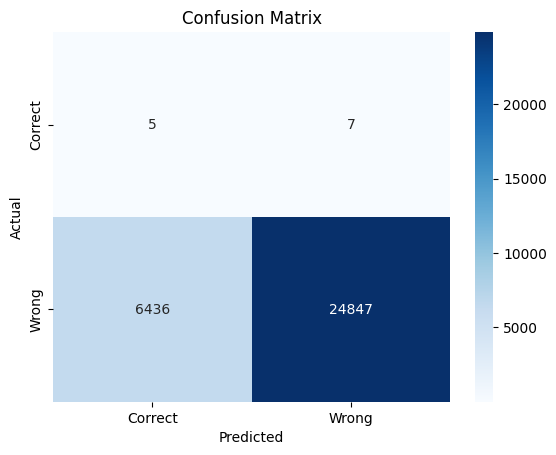

In [17]:
cm = confusion_matrix(y_train, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Correct', 'Wrong'], yticklabels=['Correct', 'Wrong'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('../src/tests-stat/matrix.png', dpi=300)
plt.show()

## Вывод матрицы в виде таблицы

In [18]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.001     0.417     0.002        12
           1      1.000     0.794     0.885     31283

    accuracy                          0.794     31295
   macro avg      0.500     0.605     0.443     31295
weighted avg      0.999     0.794     0.885     31295

